# 라이브러리 불러오기

In [ ]:
import os
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

import seaborn as sns
import matplotlib.pyplot as plt


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# 랜덤 시드 설정

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# 데이터 불러오기

In [ ]:
path = '../../data/'

In [ ]:
train_data: pd.DataFrame = pd.read_csv(path+"train.csv")
test_data: pd.DataFrame = pd.read_csv(path+'test.csv')
sample_submission: pd.DataFrame = pd.read_csv(path+'sample_submission.csv')

계절별 계약 건수

<ipython-input-11-1ef7402868f9>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=season_counts.index, y=season_counts.values, palette='viridis')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When groupin

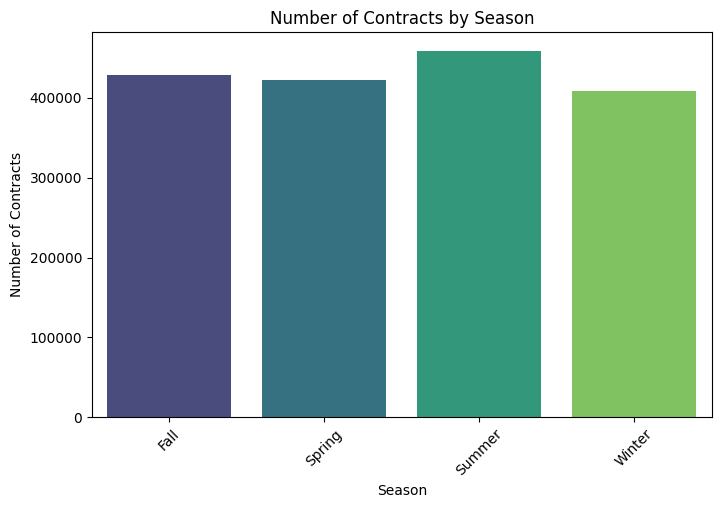

In [ ]:
# contract_year_month 컬럼에서 월 추출
train_data['month'] = (train_data['contract_year_month'] % 100)

# 월을 기준으로 계절 할당
conditions = [
    (train_data['month'] >= 3) & (train_data['month'] <= 5),  # 봄
    (train_data['month'] >= 6) & (train_data['month'] <= 8),  # 여름
    (train_data['month'] >= 9) & (train_data['month'] <= 11), # 가을
    (train_data['month'] == 12) | (train_data['month'] <= 2)  # 겨울
]

seasons = ['Spring', 'Summer', 'Fall', 'Winter']

# 새로운 컬럼에 계절 할당
train_data['season'] = np.select(conditions, seasons)

# 계절별 계약 건수 집계
season_counts = train_data['season'].value_counts().sort_index()

# 계절별 계약 건수 그래프 그리기
plt.figure(figsize=(8, 5))
sns.barplot(x=season_counts.index, y=season_counts.values, palette='viridis')
plt.title('Number of Contracts by Season')
plt.xlabel('Season')
plt.ylabel('Number of Contracts')
plt.xticks(rotation=45)
plt.show()

봄, 가을에 계약이 많다던데 아닌듯

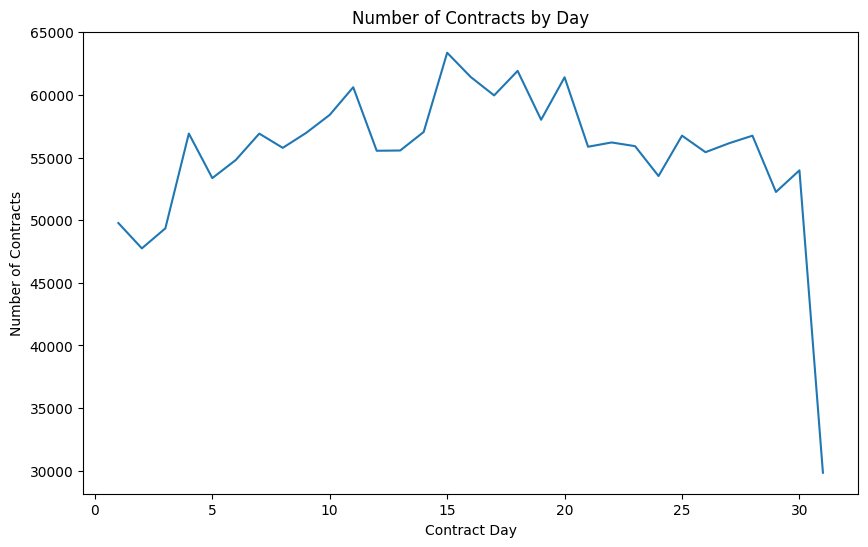

In [ ]:
# 계약 일자별 계약 수 시각화
contract_counts_by_day = train_data.groupby('contract_day').size().reset_index(name='count')

plt.figure(figsize=(10, 6))
sns.lineplot(data=contract_counts_by_day, x='contract_day', y='count')
plt.title('Number of Contracts by Day')
plt.xlabel('Contract Day')
plt.ylabel('Number of Contracts')
plt.show()


월초, 월말에 계약이 적은 경향을 보이고,  
중간 날짜에 계약이 집중되는 경향

In [ ]:
# 계약 일자가 주말인지 여부를 확인하는 새로운 컬럼 생성
train_data['contract_day_of_week'] = pd.to_datetime(train_data['contract_year_month'].astype(str) + train_data['contract_day'].astype(str), format='%Y%m%d').dt.dayofweek
# 주말과 평일 구분
train_data['is_weekend'] = train_data['contract_day_of_week'] >= 5

# 주말/평일 별 계약 수 비교
contract_weekend_counts = train_data.groupby('is_weekend').size().reset_index(name='count')


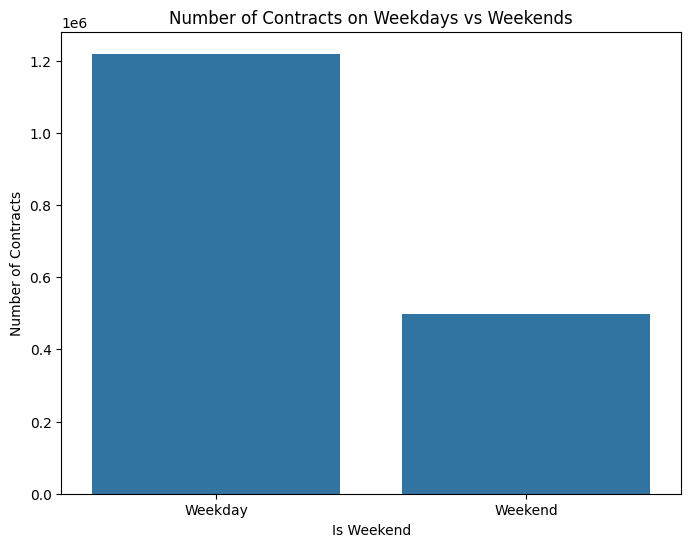

In [ ]:
# 주말/평일 계약 수 시각화
plt.figure(figsize=(8, 6))
sns.barplot(data=contract_weekend_counts, x='is_weekend', y='count')
plt.title('Number of Contracts on Weekdays vs Weekends')
plt.xlabel('Is Weekend')
plt.ylabel('Number of Contracts')
plt.xticks([0, 1], ['Weekday', 'Weekend'])  # True/False를 평일/주말로 대체
plt.show()

### 금리 데이터

In [ ]:
#추가
interestRate = pd.read_csv(path+'interestRate.csv')
parkInfo = pd.read_csv(path+'parkInfo.csv')
schoolInfo = pd.read_csv(path+'schoolinfo.csv')
subwayInfo = pd.read_csv(path+'subwayInfo.csv')


In [ ]:
# 이후에 금리 데이터를 매핑한 컬럼을 feature로 사용하기 위해 test 데이터셋도 처리해주었습니다. (기호에 맞게 사용)

train_data = pd.merge(train_data, interestRate,
                        left_on='contract_year_month',
                        right_on='year_month',
                        how='left')
test_data = pd.merge(test_data, interestRate,
                        left_on='contract_year_month',
                        right_on='year_month',
                        how='left')

In [ ]:
train_data = train_data.drop(columns=['year_month'])
test_data = test_data.drop(columns=['year_month'])

In [ ]:
train_data

In [ ]:
train_data.dtypes

,0
index,int64
area_m2,float64
contract_year_month,int64
contract_day,object
contract_type,int64
floor,int64
latitude,float64
longitude,float64
age,int64
deposit,float64


In [ ]:
print(train_data['deposit'].sort_values())

61958          300.0
58766          500.0
340618         500.0
1386557        500.0
183108         500.0
             ...    
1263316     800000.0
1201061     930000.0
1199744     950000.0
1471310    1000000.0
1340876    1100000.0
Name: deposit, Length: 1717611, dtype: float64


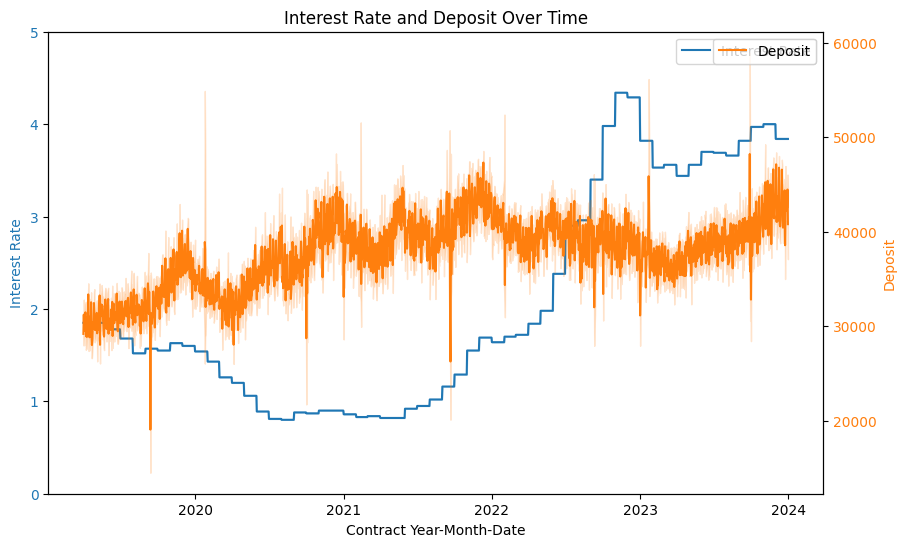

In [ ]:
# 시간에 따른 금리와 전세가의 변화
fig, ax1 = plt.subplots(figsize=(10, 6))

# 첫 번째 y축: 금리
color = 'tab:blue'
ax1.set_xlabel('Contract Year-Month-Date')
ax1.set_ylabel('Interest Rate', color=color)
sns.lineplot(data=train_data, x='contract_full_date', y='interest_rate', ax=ax1, color=color, label='Interest Rate')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, 5)

# 두 번째 y축: 전세가
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Deposit', color=color)
sns.lineplot(data=train_data, x='contract_full_date', y='deposit', ax=ax2, color=color, label='Deposit')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Interest Rate and Deposit Over Time')
plt.xticks(rotation=45)

plt.show()

금리와 전세가는 상관관계 없어보임

### 지하철 데이터

실제 대도시에서는 지하철역과 500m 이내에 위치한 부동산은 전세가가 약 5~10% 이상 더 높은 경향이 있다.  
1km 이내 거리까지는 비교적 긍정적인 영향을 미친다.

In [ ]:
train_data.index

RangeIndex(start=0, stop=1717611, step=1)

In [ ]:
from scipy.spatial import cKDTree

# 하버사인 공식 적용
def haversine(lonlat1, lonlat2):
    # 지구 반지름 (단위: 미터)
    R = 6371000

    # 위도, 경도를 라디안으로 변환
    lon1, lat1 = np.radians(lonlat1[:, 0]), np.radians(lonlat1[:, 1])
    lon2, lat2 = np.radians(lonlat2[:, 0]), np.radians(lonlat2[:, 1])

    # 차이 계산
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # 하버사인 공식 적용
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    # 거리는 R * c
    return R * c


def calculate_nearest_subway_distance(apart_coords, subway_coords):
    # cKDTree 생성
    tree = cKDTree(np.radians(subway_coords))  # 지하철 좌표를 라디안 단위로 변환하여 트리 생성

    # 모든 아파트에 대해 최근접 이웃 검색 (가장 가까운 지하철 찾기)
    distances, indices = tree.query(np.radians(apart_coords), k=1)  # 라디안으로 변환한 아파트 좌표로 최근접 이웃 검색

    # 최근접 이웃과 아파트 좌표 간의 하버사인 거리 계산
    nearest_distances = haversine(subway_coords[indices], apart_coords)

    return nearest_distances


# 아파트와 지하철의 좌표 (위도, 경도)
train_apart_coords = train_data[['latitude', 'longitude']].to_numpy()
subway_coords = subwayInfo[['latitude', 'longitude']].to_numpy()


In [ ]:
# 아파트별로 가장 가까운 지하철역까지의 거리 계산
train_data['nearest_subway_distance'] = calculate_nearest_subway_distance(train_apart_coords, subway_coords)

test_apart_coords = test_data[['latitude', 'longitude']].to_numpy()
test_data['nearest_subway_distance'] = calculate_nearest_subway_distance(test_apart_coords, subway_coords)

In [ ]:
train_data[['nearest_subway_distance']]

,nearest_subway_distance
0,857.916480
1,857.916480
2,857.916480
3,3698.482685
4,1231.527304
...,...
1717606,1811.902567
1717607,1811.902567
1717608,1811.902567
1717609,1811.902567


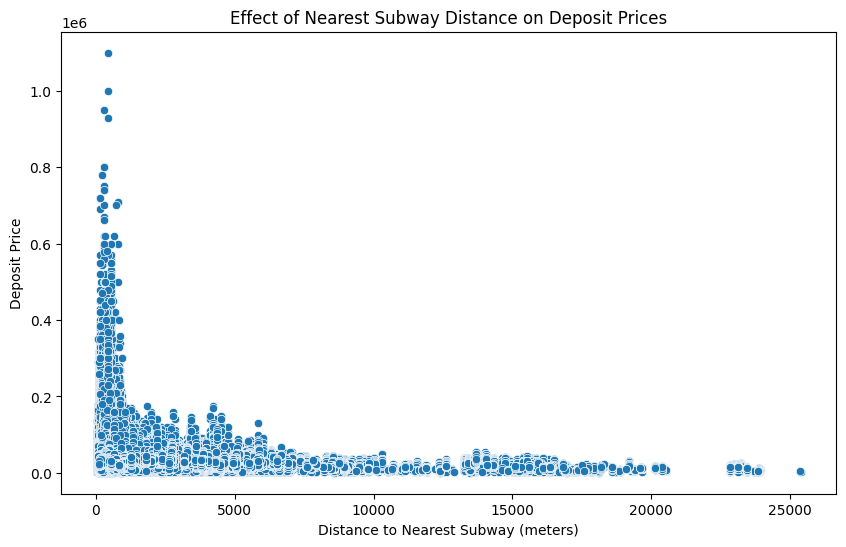

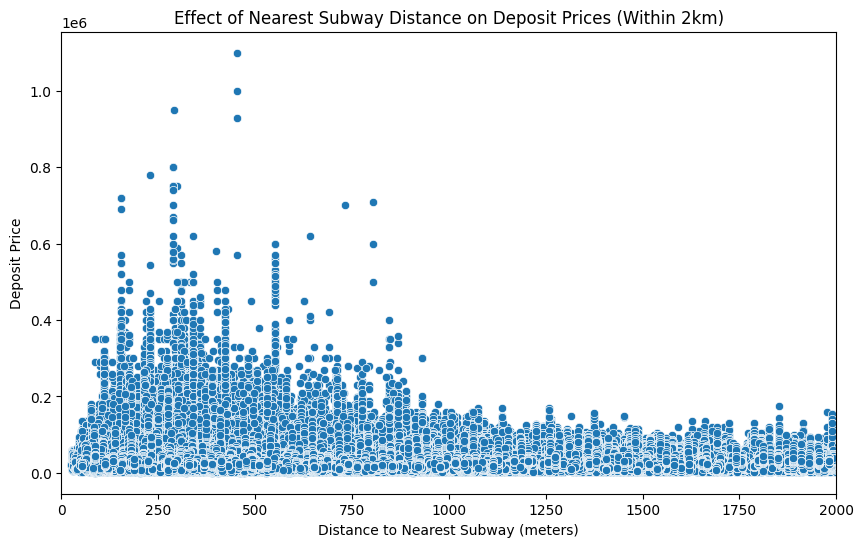

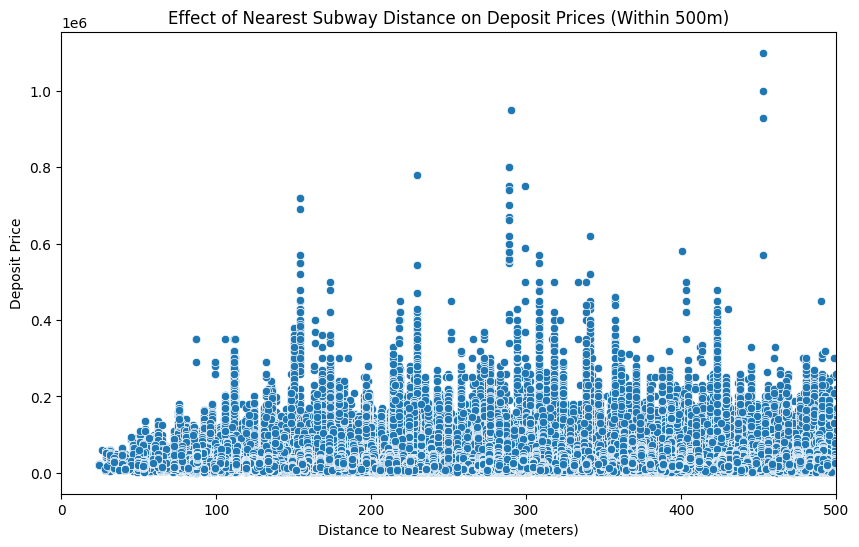

In [ ]:
# 가장 가까운 지하철역까지의 거리에 따른 전세가 비교
plt.figure(figsize=(10, 6))
sns.scatterplot(x='nearest_subway_distance', y='deposit', data=train_data)
plt.title('Effect of Nearest Subway Distance on Deposit Prices')
plt.xlabel('Distance to Nearest Subway (meters)')
plt.ylabel('Deposit Price')
plt.show()

# 지하철까지의 거리가 2km 이내에서 전세가 비교
plt.figure(figsize=(10, 6))
sns.scatterplot(x='nearest_subway_distance', y='deposit', data=train_data)
plt.title('Effect of Nearest Subway Distance on Deposit Prices (Within 2km)')
plt.xlabel('Distance to Nearest Subway (meters)')
plt.ylabel('Deposit Price')

# x축 범위 제한 (2km 이내)
plt.xlim(0, 2000)

plt.show()

# 지하철까지의 거리가 500m 이내에 전세가 비교
plt.figure(figsize=(10, 6))
sns.scatterplot(x='nearest_subway_distance', y='deposit', data=train_data)
plt.title('Effect of Nearest Subway Distance on Deposit Prices (Within 500m)')
plt.xlabel('Distance to Nearest Subway (meters)')
plt.ylabel('Deposit Price')

# x축 범위 제한 (500m 이내)
plt.xlim(0, 500)

plt.show()


- 지하철역까지의 거리가 가까울수록 전세가가 높아지는 경향을 보임
- 1km를 넘어가면 전세가가 거의 일정함
- 1km 내에서는 전세가가 다양하게 분포함
- 1km 내외를 기준으로 구분할 만한 듯 - 이진 분류?

In [ ]:
# 지하철 밀집도 계산
# 거리 범위 내의 지하철역 개수 계산
def count_subways_within_range(apart_coords, subway_coords, radius):
    """
    주어진 반경 내의 지하철역 개수를 계산하는 함수
    apart_coords: 아파트 좌표 (위도, 경도)
    subway_coords: 지하철 좌표 (위도, 경도)
    radius: 반경 (미터 단위)
    """
    # cKDTree를 사용하여 반경 내의 지하철역 탐색
    tree = cKDTree(np.radians(subway_coords))  # 라디안 변환된 지하철 좌표 사용
    apart_coords_rad = np.radians(apart_coords)  # 라디안 변환된 아파트 좌표

    # 반경 내 지하철역 찾기 (하버사인 거리 기준)
    indices_within_radius = tree.query_ball_point(apart_coords_rad, r=radius / 6371000)  # 반경을 라디안으로 변환

    # 각 아파트별 반경 내 지하철역 개수 계산
    subway_counts = [len(indices) for indices in indices_within_radius]

    return subway_counts

In [ ]:
# 반경 내 지하철역 개수
radius = 1000  # 1km 반경
train_data['subways_within_1km'] = count_subways_within_range(train_apart_coords, subway_coords, radius)

# 1km 반경 내 지하철 밀집도 계산
# 1km 반경의 면적은 약 3.141592 km² (이를 이용해 밀집도를 구함)
area_1km_km2 = (np.pi * (radius / 1000) ** 2)  # km² 단위로 면적 계산

# 밀집도를 제곱킬로미터(km²)당 지하철역 개수로 변환
train_data['subway_density_1km'] = train_data['subways_within_1km'] / area_1km_km2

# 결과 확인
print(train_data[['subways_within_1km', 'subway_density_1km']].head())


   subways_within_1km  subway_density_1km
0                   1             0.31831
1                   1             0.31831
2                   1             0.31831
3                   0             0.00000
4                   0             0.00000


In [ ]:
test_data['subways_within_1km'] = count_subways_within_range(test_apart_coords, subway_coords, radius)

# 1km 반경 내 지하철 밀집도 계산
# 1km 반경의 면적은 약 3.141592 km² (이를 이용해 밀집도를 구함)
area_1km_km2 = (np.pi * (radius / 1000) ** 2)  # km² 단위로 면적 계산

# 밀집도를 제곱킬로미터(km²)당 지하철역 개수로 변환
test_data['subway_density_1km'] = test_data['subways_within_1km'] / area_1km_km2


### 학교 데이터

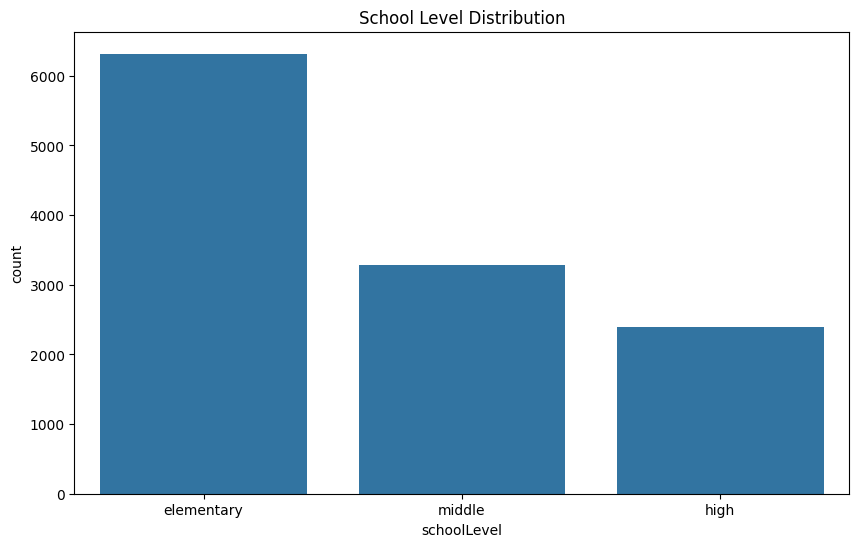

In [ ]:
# 학교 종류별 카운트

plt.figure(figsize=(10, 6))
sns.countplot(x='schoolLevel', data=schoolInfo)
plt.title('School Level Distribution')
plt.show()

In [ ]:
def calculate_nearest_school_distance(apart_coords, school_info):
    # 학교 레벨별로 거리 계산을 위한 빈 딕셔너리 초기화
    nearest_distances = {}

    # 각 학교 레벨에 대한 거리 계산
    for level in school_info['schoolLevel'].unique():
        level_coords = school_info[school_info['schoolLevel'] == level][['latitude', 'longitude']].to_numpy()

        if level_coords.shape[0] > 0:
            tree = cKDTree(level_coords)
            distances, indices = tree.query(apart_coords)

            nearest_distances[level] = haversine(tree.data[indices], apart_coords)

    return nearest_distances


# 각 아파트에 대해 가까운 학교 거리 추가
nearest_school_distances = calculate_nearest_school_distance(train_apart_coords, schoolInfo)
for level in nearest_school_distances:
    train_data[f'nearest_{level}_distance'] = nearest_school_distances[level]

nearest_school_distances = calculate_nearest_school_distance(test_apart_coords, schoolInfo)
for level in nearest_school_distances:
    test_data[f'nearest_{level}_distance'] = nearest_school_distances[level]


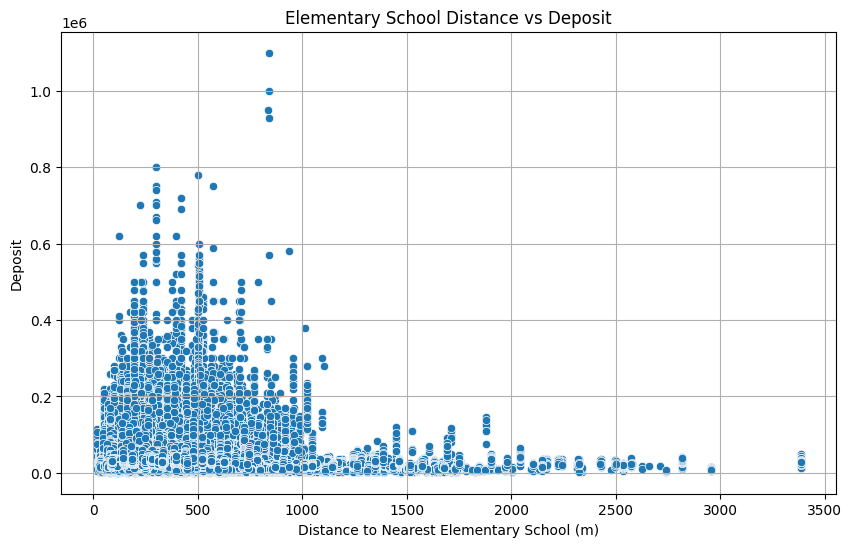

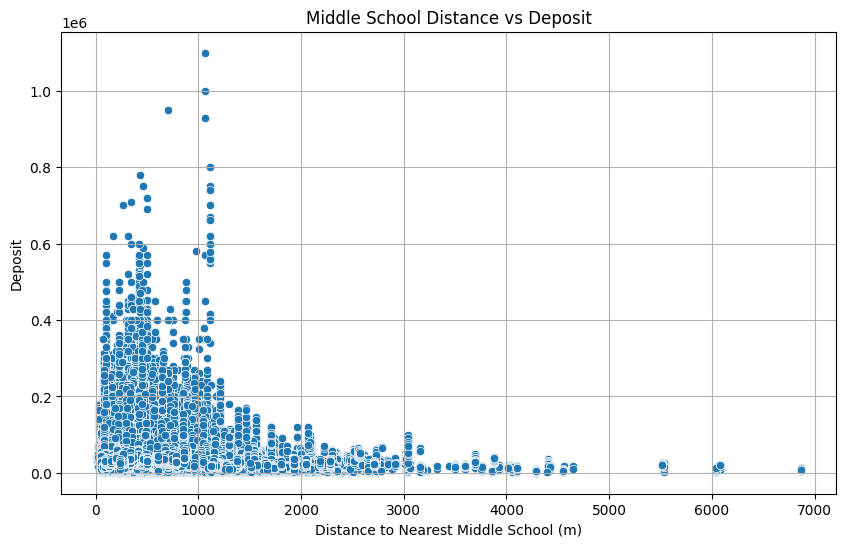

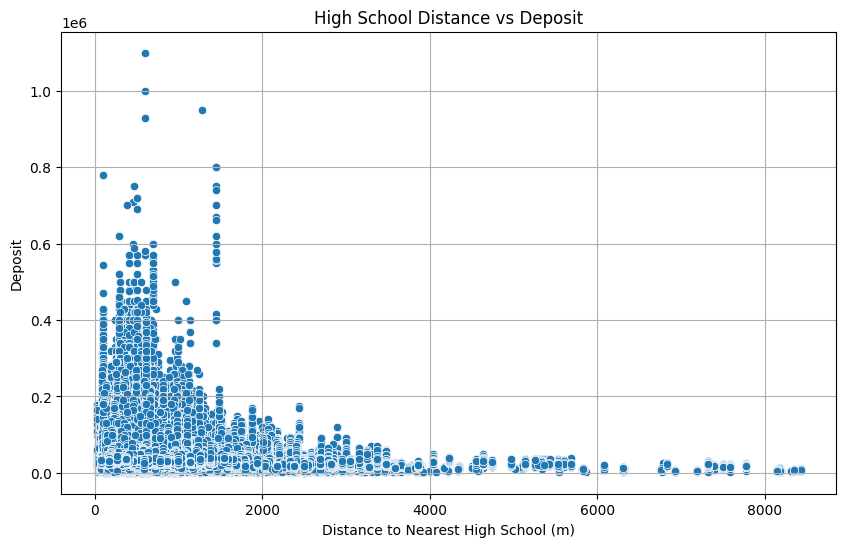

In [ ]:
for level in schoolInfo['schoolLevel'].unique():

    plt.figure(figsize=(10,6))
    sns.scatterplot(x=f'nearest_{level}_distance', y='deposit', data=train_data)
    plt.title(f'{level.capitalize()} School Distance vs Deposit')
    plt.xlabel(f'Distance to Nearest {level.capitalize()} School (m)')
    plt.ylabel('Deposit')
    plt.grid(True)
    plt.show()

### 공원 데이터

area가 0인 행 제거

In [ ]:
parkInfo = parkInfo[parkInfo['area'] > 0]

- 아파트에서 공원까지의 거리를 계산해서 전세가에 미치는 영향을 확인하고  
- 유의미한 거리 내에서 공원의 면적이 전세가에 미치는 영향 확인

In [ ]:
# 최근접 공원 거리 계산 함수
def calculate_nearest_park_distance(apart_coords, park_coords):
    tree = cKDTree(np.radians(park_coords))  # 공원 좌표를 KDTree로 변환
    distances, indices = tree.query(np.radians(apart_coords), k=1)  # 최근접 공원 거리 검색
    return haversine(apart_coords, park_coords[indices])


park_coords = parkInfo[['latitude', 'longitude']].to_numpy()

In [ ]:
# 각 아파트에 대해 가장 가까운 공원까지의 거리 계산
train_data['nearest_park_distance'] = calculate_nearest_park_distance(train_apart_coords, park_coords)

test_data['nearest_park_distance'] = calculate_nearest_park_distance(test_apart_coords, park_coords)

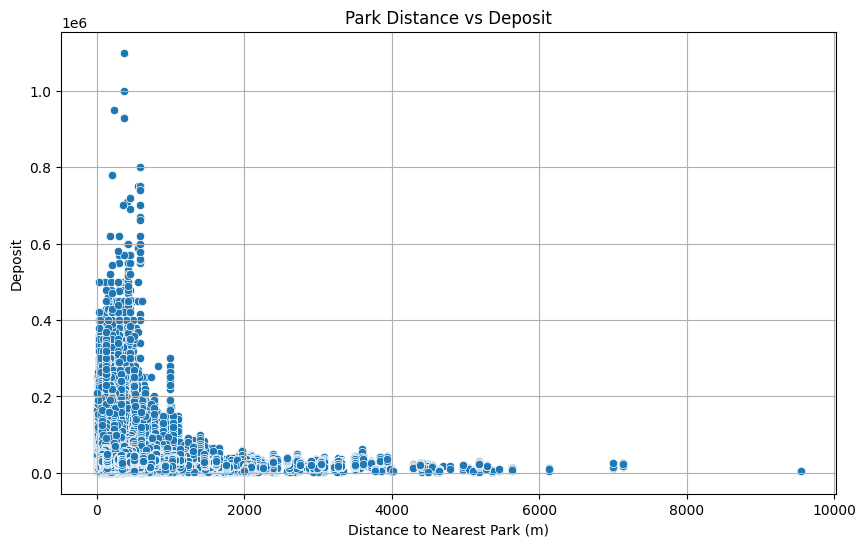

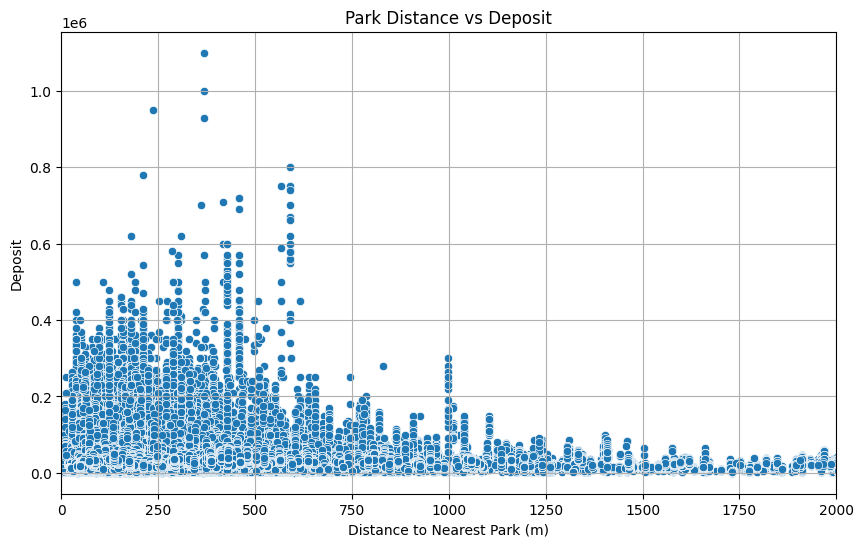

In [ ]:
# 공원까지의 거리와 전세가 시각화
plt.figure(figsize=(10, 6))

sns.scatterplot(x='nearest_park_distance', y='deposit', data=train_data)

plt.title('Park Distance vs Deposit')
plt.xlabel('Distance to Nearest Park (m)')
plt.ylabel('Deposit')
plt.grid(True)
plt.show()

# 2000m 이내일 때
plt.figure(figsize=(10, 6))

sns.scatterplot(x='nearest_park_distance', y='deposit', data=train_data)

plt.title('Park Distance vs Deposit')
plt.xlabel('Distance to Nearest Park (m)')
plt.ylabel('Deposit')
plt.xlim(0, 2000)
plt.grid(True)
plt.show()


In [ ]:
train_data['nearest_park_distance'].sort_values()

,nearest_park_distance
576583,0.002015
576623,0.002015
576622,0.002015
576621,0.002015
366250,0.002015
...,...
754859,7135.703111
1646321,9546.994272
1607590,9546.994272
1544722,9546.994272


1km 이내의 공원의 면적이 크면 전세가에 영향을 미칠까?

In [ ]:
def nearest_park_area(apart_coords, park_coords, park_areas):
    tree = cKDTree(np.radians(park_coords))  # 공원 좌표로 KDTree 생성
    distances, indices = tree.query(np.radians(apart_coords), k=1)  # 가장 가까운 공원 인덱스 검색
    return park_areas[indices]  # 가장 가까운 공원의 면적 반환

# 공원 면적 데이터
park_areas = parkInfo['area'].to_numpy()

# 각 아파트에 대해 가장 가까운 공원의 면적 추가
train_data['nearest_park_area'] = nearest_park_area(train_apart_coords, park_coords, park_areas)

test_data['nearest_park_area'] = nearest_park_area(test_apart_coords, park_coords, park_areas)

# 결과 확인
print(train_data[['nearest_park_distance', 'nearest_park_area', 'deposit']].head())


   nearest_park_distance  nearest_park_area  deposit
0             359.024159             8285.0  17000.0
1             359.024159             8285.0  23000.0
2             359.024159             8285.0  23000.0
3             160.243217             1616.0   5000.0
4             472.095753             3986.0   1800.0


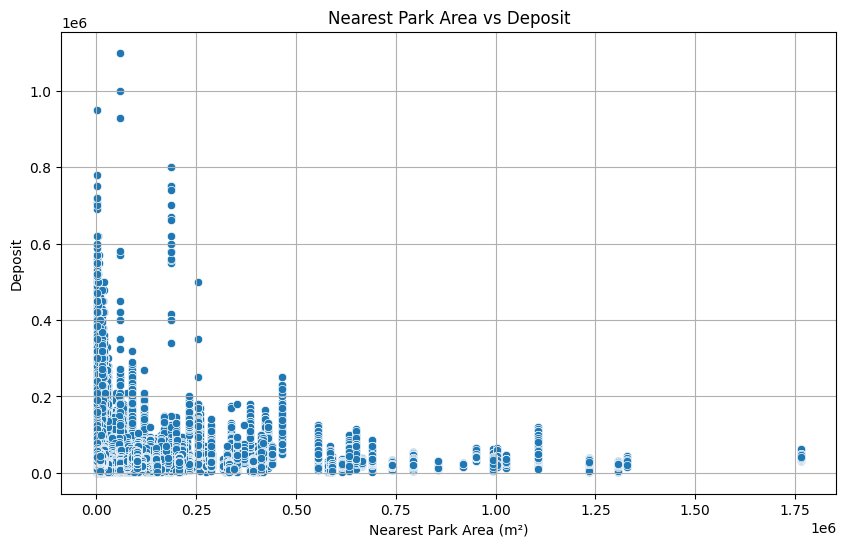

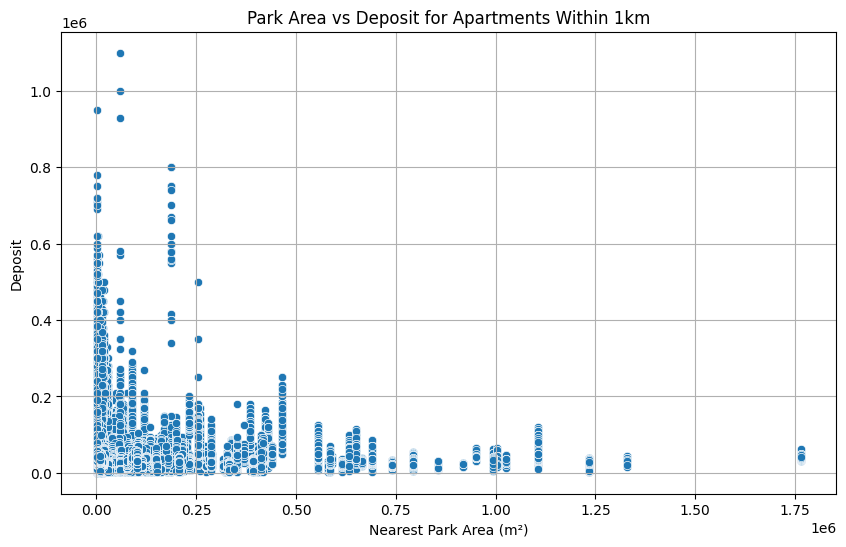

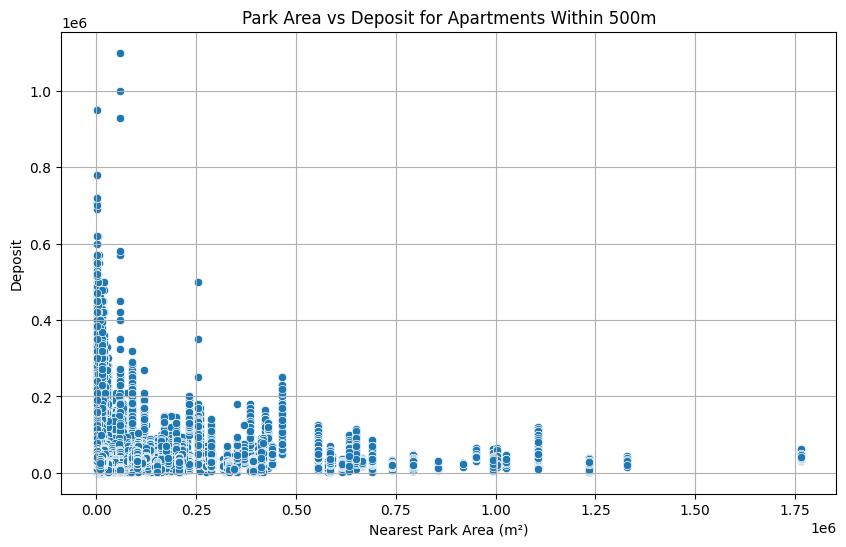

In [ ]:
# 공원 면적과 전세가의 관계 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x='nearest_park_area', y='deposit', data=train_data)

plt.title('Nearest Park Area vs Deposit')
plt.xlabel('Nearest Park Area (m²)')
plt.ylabel('Deposit')
plt.grid(True)
plt.show()


# 1km 이내에 있는 아파트 필터링
within_1km = train_data[train_data['nearest_park_distance'] <= 1000]

# 1km 이내에 있는 공원 면적과 전세가 비교
plt.figure(figsize=(10, 6))
sns.scatterplot(x='nearest_park_area', y='deposit', data=within_1km)

plt.title('Park Area vs Deposit for Apartments Within 1km')
plt.xlabel('Nearest Park Area (m²)')
plt.ylabel('Deposit')
plt.grid(True)
plt.show()


# 500m 이내에 있는 아파트 필터링
within_500m = train_data[train_data['nearest_park_distance'] <= 500]

# 500m 이내 공원 면적과 전세가 비교
plt.figure(figsize=(10, 6))
sns.scatterplot(x='nearest_park_area', y='deposit', data=within_500m)

plt.title('Park Area vs Deposit for Apartments Within 500m')
plt.xlabel('Nearest Park Area (m²)')
plt.ylabel('Deposit')
plt.grid(True)
plt.show()
